In [22]:
import pandas as pd
import numpy as np
import json
import requests
import boto3
from sklearn.preprocessing import StandardScaler
import datetime
from typing import Dict, List
from utils.preprocessing import *

features = [
    "properties.windSpeed.value",
    "properties.temperature.value",
    "properties.relativeHumidity.value"
    #'properties.cloudLayers'
]


In [23]:
bucket = "cw-weather-data"
file_name = "OHZ055_2023-08-08.json"

Here, we can import a sample of the raw data we extracted from the API.

In [24]:
s3 = boto3.client("s3")
fc = s3.get_object(Bucket=bucket, Key=f"observations/{file_name}")
file_content = fc["Body"]
dd = json.load(file_content)
df = pd.json_normalize(dd, record_path="features")

In [25]:
preprocessed_df = preprocessDataFrame(df)
start = getStart(preprocessed_df)
start_str = getStartString(preprocessed_df)

mylist = list()

for feature in features:
    mylist.append(
        featureDict(
            start_str,
            #columnNameReformat(feature),
            "target",
            preprocessQuant(preprocessed_df[feature]),
        )
    )

#write_dicts_to_file("data.json", mylist)

## Write to S3

cw-sagemaker-domain1/deep_ar/train/

the deep ar model expects the data in a certain format, which is a multiline dictionary json file. This isn't very conducive for moving data around as we always have issues with the common packages for JSON.

Idea:
make a list of dictionaries, save it as a text file
read the text file


In [26]:
#with open('data.json') as f:
#    da = 

s3 = boto3.client("s3")
bucket = "cw-sagemaker-domain-1"
key_prefix = "deep_ar/data/raw/"
file_name = "OHZ055_2023-08-08_train.json"

response = s3.put_object(Body = json.dumps(mylist), Bucket=bucket, Key=key_prefix + file_name)


# Example Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = df[features[:-1]]
y = df[features[-1]]

scaler = StandardScaler()
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features[:-1]

/var/folders/dk/w25w7v256r15pk9pvk88_y780000gn/T/ipykernel_66530/553308906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [12]:
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

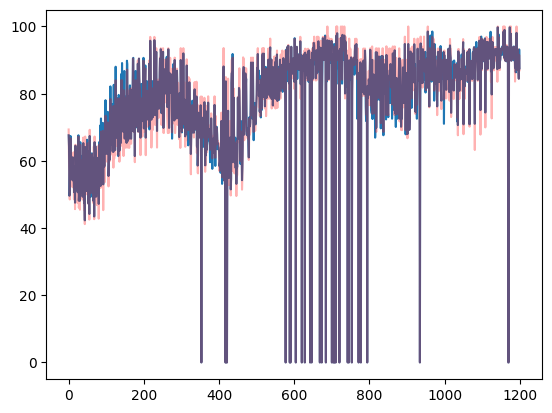

In [17]:
import matplotlib.pyplot as plt

plt.plot(model.predict(X))
plt.plot(y.values, alpha=0.3, color="r")

AttributeError: 'RandomForestRegressor' object has no attribute 'accuracy'